# MP1 : Image Classification and Regression

In [1]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D, Conv3D, advanced_activations, UpSampling2D
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    #print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
            #print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    #print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
            #print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

## 3. Simple Classification

Generate the training set

In [40]:
nb_samples = 300
[X_train, Y_train] = generate_dataset_classification(nb_samples, 20)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape) #5184 = 72 x 72 (IMAGE_SIZE =72)

X_train shape: (300, 5184)
Y_train shape: (300,)


Test - Training set

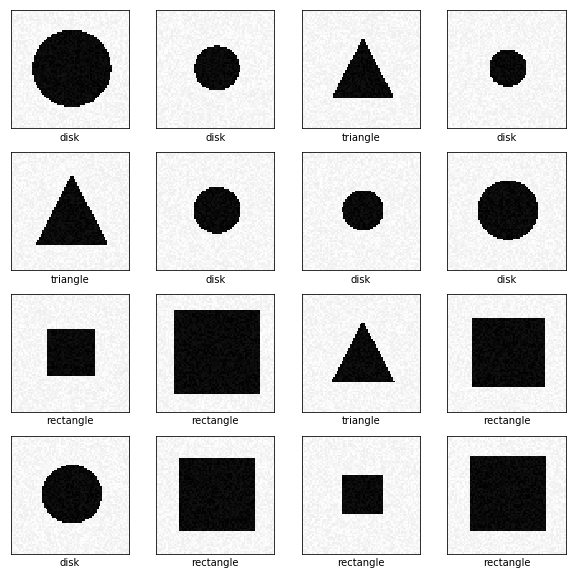

In [43]:
type_form = ['rectangle', 'disk', 'triangle']

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(72,72), cmap= 'gray')
    plt.xlabel(type_form[int(Y_train[i])])

Class modification : (0, 1, 2) into 3-element vector containing 1 for the predicted class

In [44]:
y_train = np_utils.to_categorical(Y_train, 3)

In [46]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (300, 5184)
y_train shape: (300, 3)


### 3.1 Stochastic Gradient Descent

In [47]:
#SGD optimization
model_sgd = Sequential()

model_sgd.add(Dense(16,activation='relu'))
model_sgd.add(Dense(3, activation = 'softmax'))
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model_sgd.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

model_sgd.fit(X_train, y_train, epochs=20, batch_size=32, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 0s 1ms/step - loss: 0.2383 - acc: 0.3917 - val_loss: 0.1909 - val_acc: 0.6500
Epoch 2/20
240/240 [==============================] - 0s 150us/step - loss: 0.1910 - acc: 0.5458 - val_loss: 0.1787 - val_acc: 0.5167
Epoch 3/20
240/240 [==============================] - 0s 155us/step - loss: 0.1627 - acc: 0.6208 - val_loss: 0.1688 - val_acc: 0.5833
Epoch 4/20
240/240 [==============================] - 0s 164us/step - loss: 0.1443 - acc: 0.6958 - val_loss: 0.1405 - val_acc: 0.5833
Epoch 5/20
240/240 [==============================] - 0s 160us/step - loss: 0.1331 - acc: 0.7042 - val_loss: 0.1350 - val_acc: 0.7500
Epoch 6/20
240/240 [==============================] - 0s 157us/step - loss: 0.1181 - acc: 0.8125 - val_loss: 0.1215 - val_acc: 0.8000
Epoch 7/20
240/240 [==============================] - 0s 163us/step - loss: 0.1093 - acc: 0.8125 - val_loss: 0.1312 - val_acc: 0.7500
Epoch 8/20
240/240 

Generating a test set and the prediction

In [48]:
[X_test, Y_test] = generate_dataset_classification(15, 20)
Y_pred_sgd = model_sgd.predict(X_test)

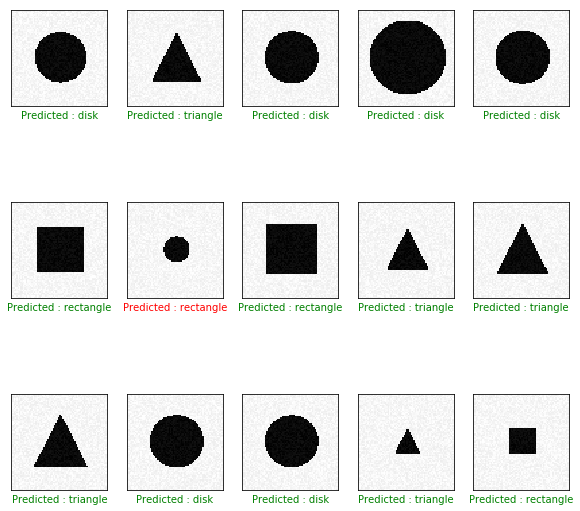

In [49]:
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i].reshape(72,72), cmap= 'gray')
    prediction_i = Y_pred_sgd[i]
    list_pred_i = list(prediction_i)
    index_pred_i = list_pred_i.index(np.max(list_pred_i))
    if index_pred_i == Y_test[i]:
        plt.xlabel('Predicted : ' + type_form[index_pred_i], color = 'g')
    else:
        plt.xlabel('Predicted : ' + type_form[index_pred_i], color = 'r')

### 3.2 Adam optimizer

In [50]:
#Adam optimization
model_adam = Sequential()

model_adam.add(Dense(16,activation='relu'))
model_adam.add(Dense(3, activation = 'softmax'))
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_adam.compile(loss='categorical_crossentropy', optimizer= adam, metrics=['accuracy'])

model_adam.fit(X_train, y_train, epochs=20, batch_size=32, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 0s 2ms/step - loss: 1.9876 - acc: 0.4375 - val_loss: 1.9561 - val_acc: 0.4167
Epoch 2/20
240/240 [==============================] - 0s 226us/step - loss: 1.2666 - acc: 0.4000 - val_loss: 0.9391 - val_acc: 0.4333
Epoch 3/20
240/240 [==============================] - 0s 220us/step - loss: 0.9804 - acc: 0.5750 - val_loss: 0.8412 - val_acc: 0.7167
Epoch 4/20
240/240 [==============================] - 0s 252us/step - loss: 0.8555 - acc: 0.5750 - val_loss: 0.8965 - val_acc: 0.5667
Epoch 5/20
240/240 [==============================] - 0s 279us/step - loss: 0.7933 - acc: 0.6542 - val_loss: 0.7363 - val_acc: 0.6833
Epoch 6/20
240/240 [==============================] - 0s 196us/step - loss: 0.7166 - acc: 0.7125 - val_loss: 0.7187 - val_acc: 0.6833
Epoch 7/20
240/240 [==============================] - 0s 168us/step - loss: 0.6970 - acc: 0.7333 - val_loss: 0.6661 - val_acc: 0.8167
Epoch 8/20
240/240 

Generating a test set and the prediction

In [51]:
Y_pred_adam = model_adam.predict(X_test)

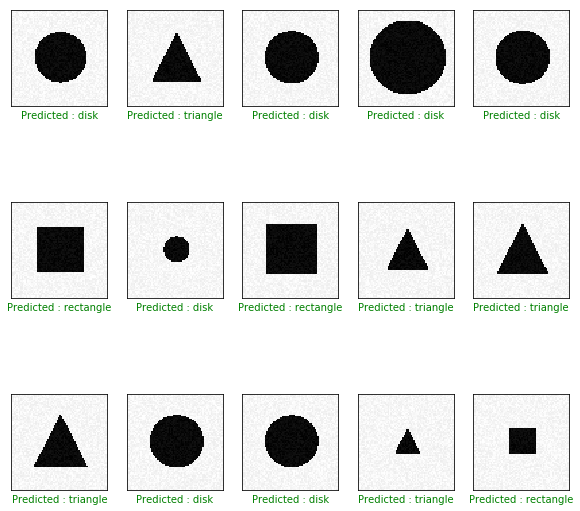

In [52]:
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i].reshape(72,72), cmap= 'gray')
    prediction_i = Y_pred_adam[i]
    list_pred_i = list(prediction_i)
    index_pred_i = list_pred_i.index(np.max(list_pred_i))
    if index_pred_i == Y_test[i]:
        plt.xlabel('Predicted : ' + type_form[index_pred_i], color = 'g')
    else:
        plt.xlabel('Predicted : ' + type_form[index_pred_i], color = 'r')

# 4. Visualization of the solution

In [53]:
W_adam = model_adam.get_weights()[0] @ model_adam.get_weights()[2]
W_adam.shape

(5184, 3)

In [54]:
b_adam = model_adam.get_weights()[3] 
b_adam.shape

(3,)

Text(0.5,1,'Adam: Third column')

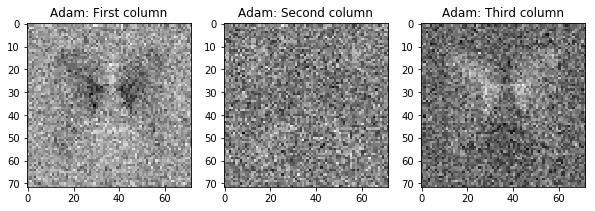

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

axes[0].imshow(W_adam[:,0].reshape(72,72), cmap='gray')
axes[0].set_title('Adam: First column')

axes[1].imshow(W_adam[:,1].reshape(72,72), cmap='gray')
axes[1].set_title('Adam: Second column')

axes[2].imshow(W_adam[:,2].reshape(72,72), cmap='gray')
axes[2].set_title('Adam: Third column')

# 5. A more difficult classification problem

Generating and reshaping X_train and Y_train

In [56]:
[X_train_1, Y_train_1] = generate_dataset_classification(700, 20, True)

X_train_1 = X_train_1.reshape((700, 72, 72, 1))
y_train_1 = np_utils.to_categorical(Y_train_1, 3)

In [57]:
print('X_train_1 shape:', X_train_1.shape)
print('y_train_1 shape:', y_train_1.shape)

X_train_1 shape: (700, 72, 72, 1)
y_train_1 shape: (700, 3)


In [58]:
model1 = Sequential()

#Convolutional Layer 
model1.add(Conv2D(16, (5, 5), activation='relu', input_shape=(72, 72, 1)))
print(model1.output_shape)

model1.add(MaxPooling2D(pool_size=(2, 2)))
print(model1.output_shape)

#Flattening 
model1.add(Flatten())
print(model1.output_shape)

model1.add(Dense(3, activation = 'softmax'))
print(model1.output_shape)

#Optimization
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   
model1.fit(X_train_1, y_train_1, epochs= 32)

(None, 68, 68, 16)
(None, 34, 34, 16)
(None, 18496)
(None, 3)
Epoch 1/32
700/700 [==============================] - 2s 3ms/step - loss: 1.1652 - acc: 0.4629
Epoch 2/32
700/700 [==============================] - 2s 3ms/step - loss: 0.8083 - acc: 0.7000
Epoch 3/32
700/700 [==============================] - 2s 3ms/step - loss: 0.7088 - acc: 0.6771
Epoch 4/32
700/700 [==============================] - 2s 3ms/step - loss: 0.6241 - acc: 0.7386
Epoch 5/32
700/700 [==============================] - 2s 3ms/step - loss: 0.5663 - acc: 0.8014
Epoch 6/32
700/700 [==============================] - 2s 3ms/step - loss: 0.5094 - acc: 0.8300
Epoch 7/32
700/700 [==============================] - 2s 3ms/step - loss: 0.4727 - acc: 0.8486
Epoch 8/32
700/700 [==============================] - 2s 3ms/step - loss: 0.4272 - acc: 0.8657
Epoch 9/32
700/700 [==============================] - 2s 3ms/step - loss: 0.3909 - acc: 0.8757
Epoch 10/32
700/700 [==============================] - 2s 3ms/step - loss: 0.3566 -

Generating X_test and Y_test

In [59]:
[X_test_1, Y_test_1] = generate_test_set_classification()

In [60]:
print('X_test_1 shape:', X_test_1.shape)
print('Y_test_1 shape:', Y_test_1.shape)

X_test_1 shape: (300, 5184)
Y_test_1 shape: (300, 3)


Reshaping X_test and Y_test

In [61]:
X_test_1 = X_test_1.reshape((300, 72, 72, 1))
y_test_1 = Y_test_1

In [62]:
print('X_test_1 shape:', X_test_1.shape)
print('y_test_1 shape:', y_test_1.shape)

X_test_1 shape: (300, 72, 72, 1)
y_test_1 shape: (300, 3)


Model Evaluation

In [63]:
model1.evaluate(X_test_1, y_test_1)

300/300 [==============================] - 1s 2ms/step


[0.5325070516268412, 0.78333333333333333]

In [64]:
y_pred_1 = model1.predict(X_test_1)

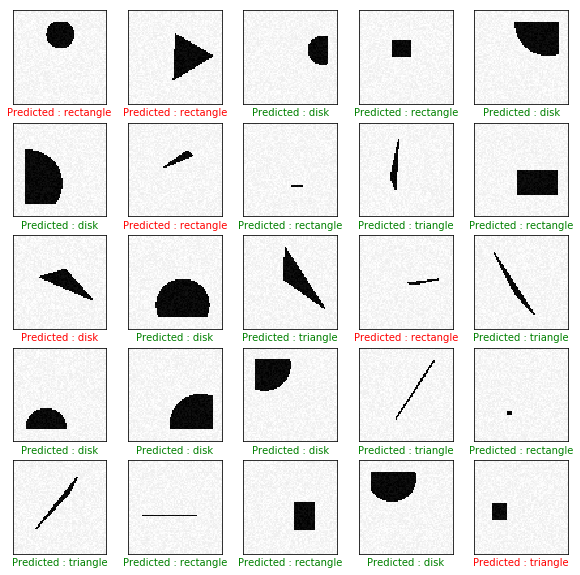

In [65]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test_1[i].reshape(72,72), cmap= 'gray')
    
    prediction_i = y_pred_1[i]
    list_pred_i = list(prediction_i)
    index_pred_i = list_pred_i.index(np.max(list_pred_i))
    
    index_to_predict = list(y_test_1[i]).index(np.max(list(y_test_1[i])))
    
    if index_pred_i == index_to_predict:
        plt.xlabel('Predicted : ' + type_form[index_pred_i], color = 'g')
    else:
        plt.xlabel('Predicted : ' + type_form[index_pred_i], color = 'r')

# 6 - A Regression Problem

In [66]:
[X_train_2, Y_train_2] = generate_dataset_regression(600, 20)

In [67]:
print('X_train_2 shape:', X_train_2.shape)
print('Y_train_2 shape:', Y_train_2.shape)

X_train_2 shape: (600, 5184)
Y_train_2 shape: (600, 6)


In [68]:
def normalize_Y(array):
    array_normalized = np.copy(array)
    nb_samples = array.shape[0]
    
    for k in range(nb_samples):
        vertices = list(array[k])
        vertices_sorted = []
        x1, y1, x2, y2, x3, y3 = vertices[0], vertices[1], vertices[2], vertices[3], vertices[4], vertices[5]

        mydict = {y1:x1, y2:x2, y3:x3}
        keylist = list(mydict.keys())
        keylist.sort(reverse = True)
        for key in keylist:
            vertices_sorted.append(mydict[key])
            vertices_sorted.append(key)

        array_normalized[k] = vertices_sorted
        
    return(array_normalized)

In [69]:
X_train_2 = X_train_2.reshape((600, 72, 72, 1))
y_train_2 = normalize_Y(Y_train_2)

In [70]:
print('X_train_2 shape:', X_train_2.shape)
print('y_train_2 shape:', y_train_2.shape)

X_train_2 shape: (600, 72, 72, 1)
y_train_2 shape: (600, 6)


Training example

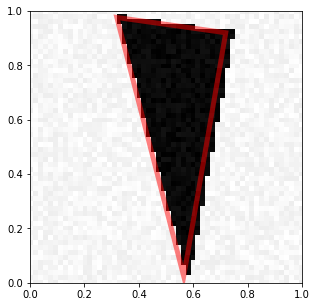

In [71]:
visualize_prediction(X_train_2[0], y_train_2[0])

Regression model

In [73]:
model2 = Sequential()

#Convolutional
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(72, 72, 1)))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu', input_shape=(72, 72, 1)))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (3, 3), activation='relu', input_shape=(72, 72, 1)))
model2.add(MaxPooling2D(pool_size=(2, 2)))

#Flattening 
model2.add(Flatten())

model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(128, activation='relu'))

model2.add(Dense(6, activation = 'linear'))

#Optimization
model2.compile(loss='mean_squared_error', optimizer='adam')   
model2.fit(X_train_2, y_train_2, epochs= 25, batch_size = 20, validation_split = 0.4)

Train on 360 samples, validate on 240 samples
Epoch 1/25
360/360 [==============================] - 6s 17ms/step - loss: 0.1189 - val_loss: 0.0619
Epoch 2/25
360/360 [==============================] - 5s 14ms/step - loss: 0.0587 - val_loss: 0.0477
Epoch 3/25
360/360 [==============================] - 5s 14ms/step - loss: 0.0473 - val_loss: 0.0441
Epoch 4/25
360/360 [==============================] - 5s 15ms/step - loss: 0.0436 - val_loss: 0.0373
Epoch 5/25
360/360 [==============================] - 5s 14ms/step - loss: 0.0374 - val_loss: 0.0322
Epoch 6/25
360/360 [==============================] - 5s 13ms/step - loss: 0.0358 - val_loss: 0.0300
Epoch 7/25
360/360 [==============================] - 5s 14ms/step - loss: 0.0315 - val_loss: 0.0288
Epoch 8/25
360/360 [==============================] - 5s 13ms/step - loss: 0.0305 - val_loss: 0.0312
Epoch 9/25
360/360 [==============================] - 5s 13ms/step - loss: 0.0276 - val_loss: 0.0234
Epoch 10/25
360/360 [========================

In [74]:
[X_test_2, Y_test_2] = generate_test_set_regression()

In [75]:
print('X_train_2 shape:', X_train_2.shape)
print('y_train_2 shape:', y_train_2.shape)

X_train_2 shape: (600, 72, 72, 1)
y_train_2 shape: (600, 6)


In [76]:
X_test_2 = X_test_2.reshape((300, 72, 72, 1))
y_test_2 = normalize_Y(Y_test_2)

In [77]:
print('X_test_2 shape:', X_test_2.shape)
print('y_test_2 shape:', y_test_2.shape)

X_test_2 shape: (300, 72, 72, 1)
y_test_2 shape: (300, 6)


In [78]:
print(Y_test_2[0])
print(y_test_2[0])

[ 0.94133439  0.93818117  0.67661723  0.27556678  0.36340393  0.33217252]
[ 0.94133439  0.93818117  0.36340393  0.33217252  0.67661723  0.27556678]


In [79]:
model2.evaluate(X_test_2, y_test_2)

300/300 [==============================] - 1s 4ms/step


0.016155412358542284

In [80]:
y_pred_2 = model2.predict(X_test_2)

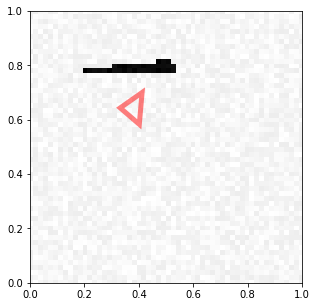

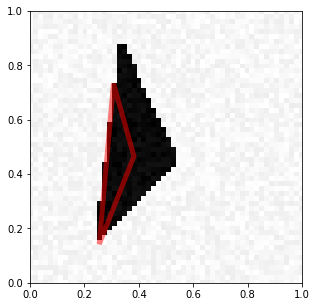

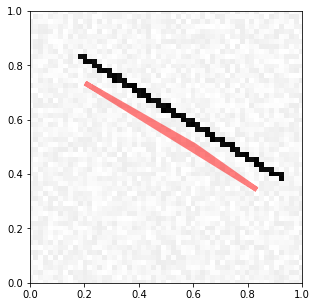

In [81]:
visualize_prediction(X_test_2[1], y_pred_2[1])
visualize_prediction(X_test_2[2], y_pred_2[2])
visualize_prediction(X_test_2[3], y_pred_2[3])

## 7 - Image Denoising

In [82]:
IMAGE_SIZE = 72

def generate_a_drawing_bis(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noised = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata_noised, imdata

def generate_a_rectangle_bis(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing_bis(figsize, U, V, noise)


def generate_a_disk_bis(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing_bis(figsize, U, V, noise)

def generate_a_triangle_bis(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata_noised, imdata = generate_a_drawing_bis(figsize, U, V, noise)
    return [imdata_noised, imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification_bis(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle_bis()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    #print('Creating data:')
    for i in range(nb_samples):
        noise_i = np.random.randint(255)
        #if i % 10 == 0:
            #print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle_bis(noise, free_location)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk_bis(noise, free_location)
        else:
            [X[i], Y[i], V] = generate_a_triangle_bis(noise, free_location)
        X[i] = (X[i] + noise) / (255 + 2 * noise)
        Y[i] = Y[i] / 255
    return [X, Y]

def generate_test_set_classification_bis():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification_bis(300, 20, True)
    return [X_test, Y_test]

In [83]:
X_noised_train, Y_denoised_train = generate_dataset_classification_bis(600, 50, True)

In [84]:
X_noised_train = X_noised_train.reshape((600, 72, 72, 1))
Y_denoised_train = Y_denoised_train.reshape((600, 72, 72, 1))

In [85]:
print('X_noised_train shape:', X_noised_train.shape)
print('Y_denoised_train shape:', Y_denoised_train.shape)

X_noised_train shape: (600, 72, 72, 1)
Y_denoised_train shape: (600, 72, 72, 1)


Text(0.5,1,'Denoised image generated')

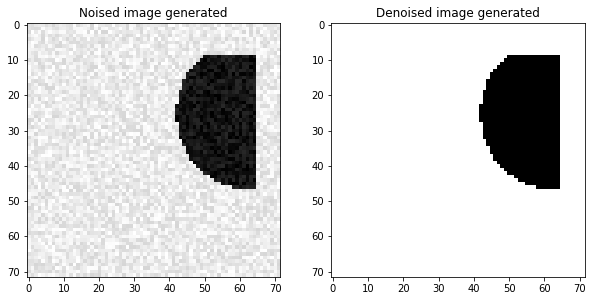

In [86]:
f, axes = plt.subplots(1, 2, figsize=(10,10))

axes[0].imshow(X_noised_train[2].reshape(72,72), cmap= 'gray')
axes[0].set_title('Noised image generated')
    
axes[1].imshow(Y_denoised_train[2].reshape(72,72), cmap= 'gray')
axes[1].set_title('Denoised image generated')


In [87]:
X_noised_test, Y_denoised_test = generate_test_set_classification_bis()

In [88]:
X_noised_test = X_noised_test.reshape((300, 72, 72, 1))
Y_denoised_test = Y_denoised_test.reshape((300, 72, 72, 1))

X_noised_test shape: (300, 72, 72, 1)
Y_denoised_test shape: (300, 72, 72, 1)


In [ ]:
print('X_noised_test shape:', X_noised_test.shape)
print('Y_denoised_test shape:', Y_denoised_test.shape)

In [89]:
model3 = Sequential()

model3.add(Conv2D(32, kernel_size=(3,3),activation='linear',input_shape=(72,72,1), padding='same'))
model3.add(advanced_activations.LeakyReLU(alpha=0.1))
print(model3.output_shape)

model3.add(MaxPooling2D(pool_size=(2, 2)))
print(model3.output_shape)

model3.add(Conv2D(64, kernel_size=(3,3),activation='linear', padding='same'))
model3.add(advanced_activations.LeakyReLU(alpha=0.1))
print(model3.output_shape)

model3.add(MaxPooling2D(pool_size=(2, 2)))
print(model3.output_shape)

model3.add(Conv2D(32, kernel_size=(3,3),activation='linear', padding='same'))
model3.add(advanced_activations.LeakyReLU(alpha=0.1))
print(model3.output_shape)

model3.add(UpSampling2D(size=(2, 2)))
print(model3.output_shape)

model3.add(Conv2D(32, kernel_size=(3,3),activation='linear', padding='same'))
model3.add(UpSampling2D(size=(2, 2)))
model3.add(advanced_activations.LeakyReLU(alpha=0.1))
print(model3.output_shape)

model3.add(Conv2D(1, kernel_size=(3,3),activation='sigmoid', padding='same'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model3.compile(loss='mean_squared_error', optimizer = adam ,metrics=['accuracy'])

model3.fit(X_noised_train, Y_denoised_train, epochs= 30, batch_size = 20, validation_split = 0.4)

(None, 72, 72, 32)
(None, 36, 36, 32)
(None, 36, 36, 64)
(None, 18, 18, 64)
(None, 18, 18, 32)
(None, 36, 36, 32)
(None, 72, 72, 32)
Train on 360 samples, validate on 240 samples
Epoch 1/30
360/360 [==============================] - 12s 34ms/step - loss: 0.1141 - acc: 0.8647 - val_loss: 0.0818 - val_acc: 0.9142
Epoch 2/30
360/360 [==============================] - 12s 34ms/step - loss: 0.0717 - acc: 0.9107 - val_loss: 0.0398 - val_acc: 0.9560
Epoch 3/30
360/360 [==============================] - 12s 33ms/step - loss: 0.0170 - acc: 0.9823 - val_loss: 0.0067 - val_acc: 0.9912
Epoch 4/30
360/360 [==============================] - 11s 32ms/step - loss: 0.0067 - acc: 0.9911 - val_loss: 0.0063 - val_acc: 0.9915
Epoch 5/30
360/360 [==============================] - 11s 30ms/step - loss: 0.0055 - acc: 0.9929 - val_loss: 0.0054 - val_acc: 0.9932
Epoch 6/30
360/360 [==============================] - 11s 30ms/step - loss: 0.0050 - acc: 0.9936 - val_loss: 0.0048 - val_acc: 0.9939
Epoch 7/30
360/36

In [90]:
Y_pred_denoised = model3.predict(X_noised_test)

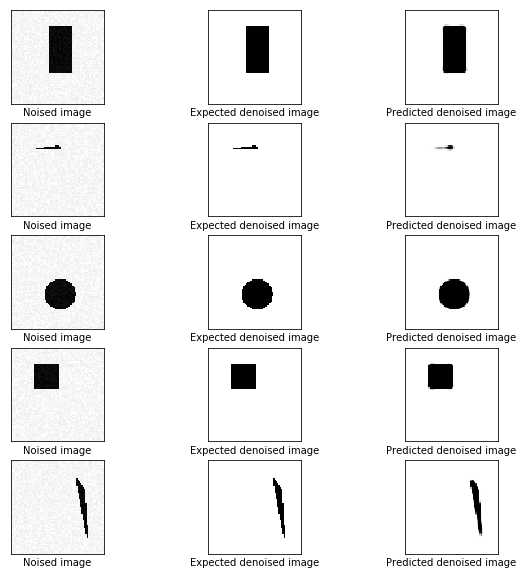

In [91]:
plt.figure(figsize=(10,10))
c = 5
for i in range(5):
    for k in range(1,4):
        plt.subplot(5,3,3*i+k)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        if k ==1:
            plt.imshow(X_noised_test[i].reshape(72,72), cmap= 'gray')
            plt.xlabel('Noised image')
        elif k ==2:
            plt.imshow(Y_denoised_test[i].reshape(72,72), cmap= 'gray')
            plt.xlabel('Expected denoised image')
        elif k ==3:
            plt.imshow(Y_pred_denoised[i].reshape(72,72), cmap= 'gray')
            plt.xlabel('Predicted denoised image')